## Setup

In [25]:
library(car)
library(MASS)
library(dplyr)
library(corrplot)
library(ggplot2)
library(Hmisc)
library(glmnet)
library(randomForest)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine




In [3]:
df = read.csv("C:/Users/ddrye/OneDrive/Documents/OMSA_Program/OMSA 2023/Summer2023/Practicum/off_git/data/2014_2020_all_tract.csv")

# select year of interest and filter out negative values for svi fields
df <- df %>% filter(year == 2020) %>% filter(socioeconomic >= 0 & household_comp >= 0 & minority_status >= 0 & housing_type >= 0 & overall_svi >=0)
colnames(df)

# select fields
df <- df[,c('total_population','housing_units','num_households','unemployment','socioeconomic','household_comp','minority_status','housing_type', 'overall_svi','avg_co2')]

# remove rows with na value(s)
df <- na.omit(df)

# outlier control applied to each column. Cut rows that contain at least one value that is 3.0 standard deviations away from the mean 
z_scores <- as.data.frame(sapply(df, function(df) (abs(df-mean(df))/sd(df))))
df <- df[!rowSums(z_scores>3), ]
head(df)

# scaling is not necessary
#df <- as.data.frame(scale(df))
#head(df)

[1] "longitude"          "latitude"           "FIPS"              
 [4] "avg_co2"            "year"               "ST"                
 [7] "STATE"              "ST_ABBR"            "STCNTY"            
[10] "COUNTY"             "FIPS.1"             "LOCATION"          
[13] "year.1"             "total_population"   "housing_units"     
[16] "num_households"     "unemployment"       "socioeconomic"     
[19] "household_comp"     "minority_status"    "housing_type"      
[22] "overall_svi"        "xco2_std"           "co2_1yr_change"    
[25] "co2_6yr_change"     "co2_1yr_pct_change" "co2_6yr_pct_change"
[28] "co2_5yr_pct_change" "co2_4yr_pct_change" "co2_3yr_pct_change"
[31] "co2_2yr_pct_change"

,total_population,housing_units,num_households,unemployment,socioeconomic,household_comp,minority_status,housing_type,overall_svi,avg_co2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3447,1141,1053,77,0.5848,0.6889,0.9285,0.0703,0.4542,413.2966
2,1507,824,635,60,0.9752,0.8203,0.7353,0.9113,0.9626,412.6768
3,4055,1522,1239,47,0.8607,0.9384,0.8798,0.7840,0.9268,413.0576
4,2728,1077,1057,42,0.2345,0.6057,0.6860,0.3554,0.3741,413.4645
5,4045,2118,1437,101,0.5609,0.7525,0.0977,0.6935,0.6183,412.7970
6,3257,1179,1179,48,0.1135,0.4199,0.2724,0.1507,0.1288,412.3908


## Initial Model

In [4]:
model1<-lm(avg_co2 ~ . , data=df)
summary(model1)


Call:
lm(formula = avg_co2 ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.48621 -0.27301 -0.00078  0.23582  1.48224 

Coefficients:
                   Estimate Std. Error   t value Pr(>|t|)    
(Intercept)       4.128e+02  9.774e-03 42235.799  < 2e-16 ***
total_population  8.228e-05  2.386e-06    34.484  < 2e-16 ***
housing_units     2.430e-05  8.018e-06     3.030  0.00245 ** 
num_households   -2.063e-04  1.095e-05   -18.836  < 2e-16 ***
unemployment      2.491e-04  2.918e-05     8.535  < 2e-16 ***
socioeconomic    -1.743e-01  3.040e-02    -5.732 9.99e-09 ***
household_comp   -2.755e-02  1.679e-02    -1.641  0.10081    
minority_status   6.059e-01  1.011e-02    59.906  < 2e-16 ***
housing_type      1.118e-01  2.112e-02     5.293 1.21e-07 ***
overall_svi      -1.788e-01  5.643e-02    -3.169  0.00153 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3903 on 58484 degrees of freedom
Multiple R-squared:  0.1614

$R^2$ is 0.16914, i.e. 16.14% of the variation in avg_co2 is explained by the predictors. At a significance level of 0.05, we reject the null hypothesis that the variables in the model hold no predictive power. In terms of individual variables, all are statistically significant except for household_comp

## Regression Assumptions

### linearity

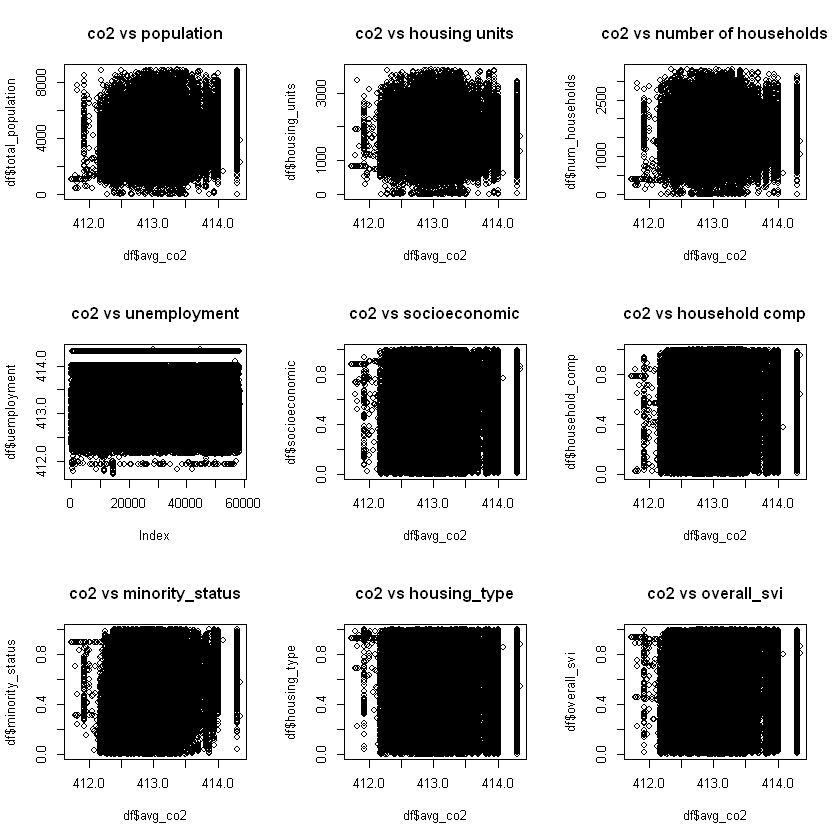

In [5]:
# pairplots
par(mfrow=c(3,3))
plot(df$avg_co2, df$total_population, main='co2 vs population')
plot(df$avg_co2, df$housing_units, main='co2 vs housing units')
plot(df$avg_co2, df$num_households, main='co2 vs number of households')
plot(df$avg_co2, df$uemployment, main='co2 vs unemployment')
plot(df$avg_co2, df$socioeconomic, main='co2 vs socioeconomic')
plot(df$avg_co2, df$household_comp, main='co2 vs household comp')
plot(df$avg_co2, df$minority_status, main='co2 vs minority_status')
plot(df$avg_co2, df$housing_type, main='co2 vs housing_type')
plot(df$avg_co2, df$overall_svi, main='co2 vs overall_svi')

No discernable relationships between the variables and avg_co2. Tranformations for the data are not apparent, or just not necessary

### Multicollinearity

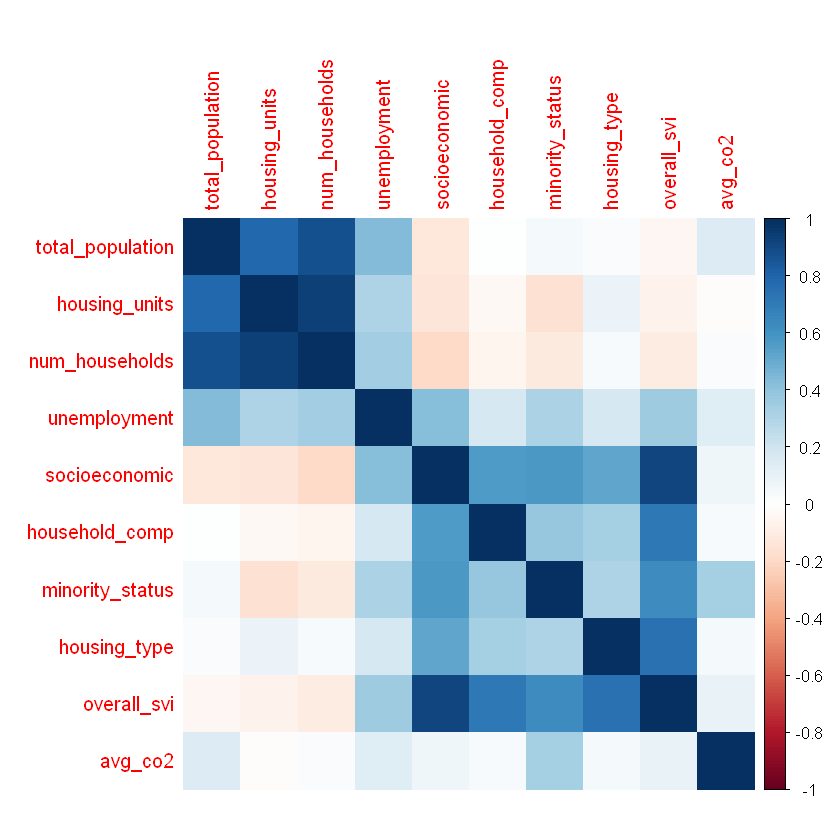

In [6]:
corrplot(cor(df), method="color")

### residuals vs fitted 

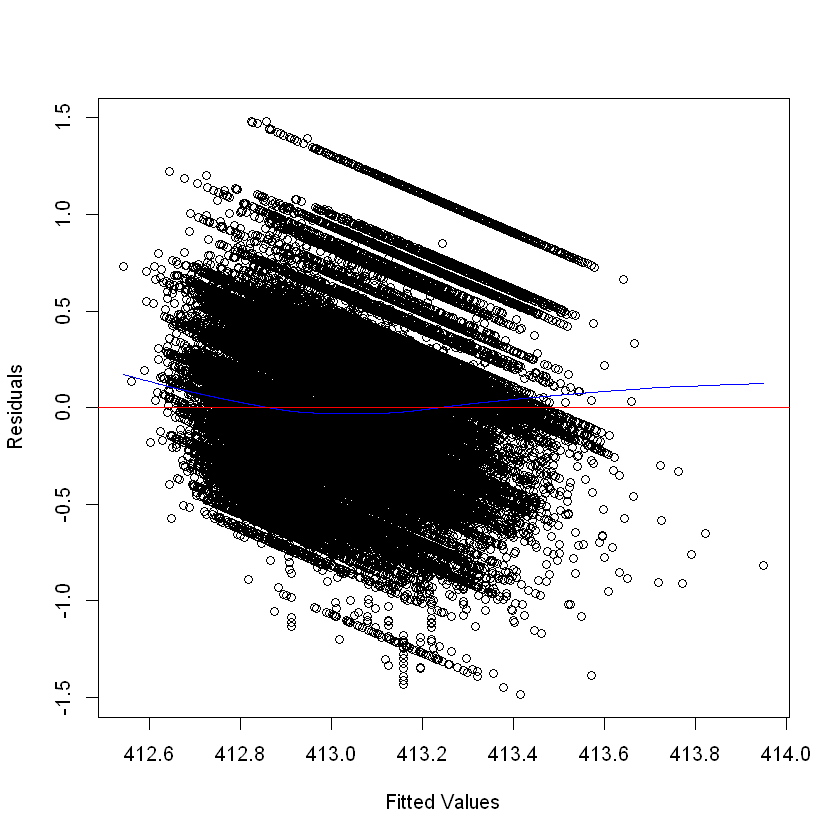

In [9]:
plot(model1$fitted.values, resids, xlab="Fitted Values", ylab="Residuals")
lines(lowess(model1$fitted.values, resids), col='blue')
abline(h=0, col="red")

### Normality

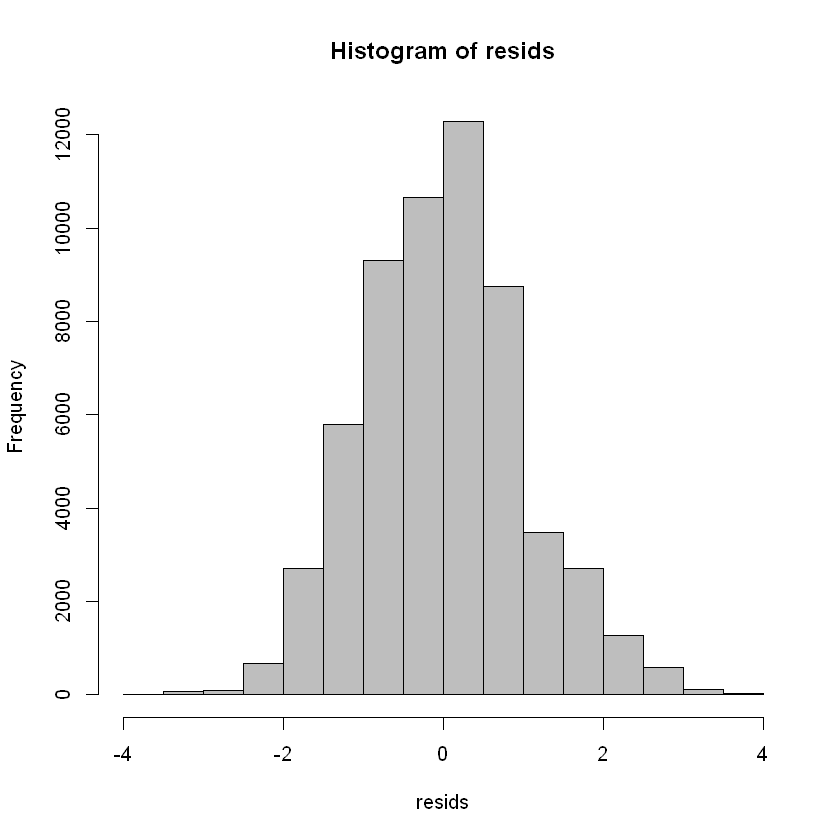

10833  4155 
10335  3961

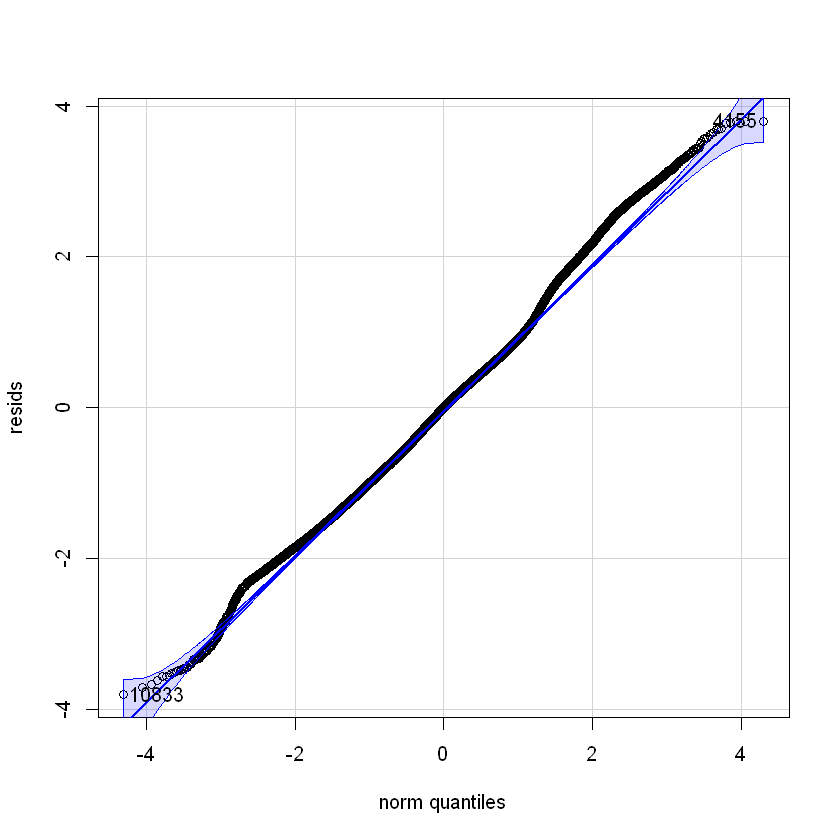

In [6]:
# Histogram of standardized residuals
hist(resids, col="grey", nclass=15)
qqPlot(resids)



Normality assumptions appears to roughly hold

## Improving the model

Backwards

In [10]:
set.seed(42)

# Create the minimum model
minmod <- lm(avg_co2 ~1, data = df)
# Step backward from the full model using BIC as the complexity penalty
model2 <- step(model1, direction='backward', scope=formula(minmod), trace=0)
#direction = "backward", scope=formula(all), trace=0)
# Show the optimal model
summary(model2)


Call:
lm(formula = avg_co2 ~ total_population + housing_units + num_households + 
    unemployment + socioeconomic + household_comp + minority_status + 
    housing_type + overall_svi, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.48621 -0.27301 -0.00078  0.23582  1.48224 

Coefficients:
                   Estimate Std. Error   t value Pr(>|t|)    
(Intercept)       4.128e+02  9.774e-03 42235.799  < 2e-16 ***
total_population  8.228e-05  2.386e-06    34.484  < 2e-16 ***
housing_units     2.430e-05  8.018e-06     3.030  0.00245 ** 
num_households   -2.063e-04  1.095e-05   -18.836  < 2e-16 ***
unemployment      2.491e-04  2.918e-05     8.535  < 2e-16 ***
socioeconomic    -1.743e-01  3.040e-02    -5.732 9.99e-09 ***
household_comp   -2.755e-02  1.679e-02    -1.641  0.10081    
minority_status   6.059e-01  1.011e-02    59.906  < 2e-16 ***
housing_type      1.118e-01  2.112e-02     5.293 1.21e-07 ***
overall_svi      -1.788e-01  5.643e-02    -3.169  0.00153 ** 
--

Forwards

In [11]:
# Step forward from the full model using BIC as the complexity penalty
model3 <- step(minmod, direction='forward', scope=formula(model1), trace=0)
#direction = "backward", scope=formula(all), trace=0)
# Show the optimal model
summary(model3)



Call:
lm(formula = avg_co2 ~ minority_status + socioeconomic + total_population + 
    num_households + household_comp + unemployment + housing_type + 
    overall_svi + housing_units, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.48621 -0.27301 -0.00078  0.23582  1.48224 

Coefficients:
                   Estimate Std. Error   t value Pr(>|t|)    
(Intercept)       4.128e+02  9.774e-03 42235.799  < 2e-16 ***
minority_status   6.059e-01  1.011e-02    59.906  < 2e-16 ***
socioeconomic    -1.743e-01  3.040e-02    -5.732 9.99e-09 ***
total_population  8.228e-05  2.386e-06    34.484  < 2e-16 ***
num_households   -2.063e-04  1.095e-05   -18.836  < 2e-16 ***
household_comp   -2.755e-02  1.679e-02    -1.641  0.10081    
unemployment      2.491e-04  2.918e-05     8.535  < 2e-16 ***
housing_type      1.118e-01  2.112e-02     5.293 1.21e-07 ***
overall_svi      -1.788e-01  5.643e-02    -3.169  0.00153 ** 
housing_units     2.430e-05  8.018e-06     3.030  0.00245 ** 
--

In [12]:
model4 <- lm(avg_co2 ~ . - household_comp, data=df)
summary(model4)


Call:
lm(formula = avg_co2 ~ . - household_comp, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.48369 -0.27267 -0.00105  0.23573  1.48281 

Coefficients:
                   Estimate Std. Error   t value Pr(>|t|)    
(Intercept)       4.128e+02  6.753e-03 61129.200  < 2e-16 ***
total_population  8.212e-05  2.384e-06    34.446  < 2e-16 ***
housing_units     2.451e-05  8.017e-06     3.057  0.00224 ** 
num_households   -2.061e-04  1.095e-05   -18.814  < 2e-16 ***
unemployment      2.485e-04  2.918e-05     8.514  < 2e-16 ***
socioeconomic    -1.341e-01  1.805e-02    -7.430  1.1e-13 ***
minority_status   6.159e-01  8.083e-03    76.204  < 2e-16 ***
housing_type      1.414e-01  1.101e-02    12.842  < 2e-16 ***
overall_svi      -2.629e-01  2.361e-02   -11.135  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3903 on 58485 degrees of freedom
Multiple R-squared:  0.1614,	Adjusted R-squared:  0.1613 
F-statistic:  

Elastic Net

In [22]:
# Optimize lambda using cross validation
cv.elnet <- cv.glmnet(as.matrix(df[,-10]), df[,10], alpha = 0.5, nfolds=10)
model5 <- glmnet(as.matrix(df[,-10]), df[,10], alpha = 0.5)

cv.elnet$lambda.min
coef(model5,s=cv.elnet$lambda.min)

[1] 0.0002214857

10 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)       4.128223e+02
total_population  8.133527e-05
housing_units     1.905389e-05
num_households   -1.983838e-04
unemployment      2.477582e-04
socioeconomic    -2.023224e-01
household_comp   -4.399602e-02
minority_status   5.969810e-01
housing_type      8.883717e-02
overall_svi      -1.177466e-01

In [23]:
model5 <- lm(avg_co2 ~ . -overall_svi, data=df)
summary(model5)


Call:
lm(formula = avg_co2 ~ . - overall_svi, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.49075 -0.27300 -0.00075  0.23593  1.48290 

Coefficients:
                   Estimate Std. Error   t value Pr(>|t|)    
(Intercept)       4.128e+02  6.466e-03 63848.722  < 2e-16 ***
total_population  8.236e-05  2.386e-06    34.520  < 2e-16 ***
housing_units     2.413e-05  8.019e-06     3.009  0.00262 ** 
num_households   -2.072e-04  1.095e-05   -18.919  < 2e-16 ***
unemployment      2.566e-04  2.909e-05     8.822  < 2e-16 ***
socioeconomic    -2.654e-01  9.795e-03   -27.102  < 2e-16 ***
household_comp   -7.586e-02  7.024e-03   -10.799  < 2e-16 ***
minority_status   5.839e-01  7.343e-03    79.513  < 2e-16 ***
housing_type      4.854e-02  6.902e-03     7.033 2.04e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3904 on 58485 degrees of freedom
Multiple R-squared:  0.1613,	Adjusted R-squared:  0.1612 
F-statistic:  140

In [26]:
set.seed(4543)
rf.fit <- randomForest(avg_co2 ~ ., data=df, ntree=1000,
                       keep.forest=FALSE, importance=TRUE)

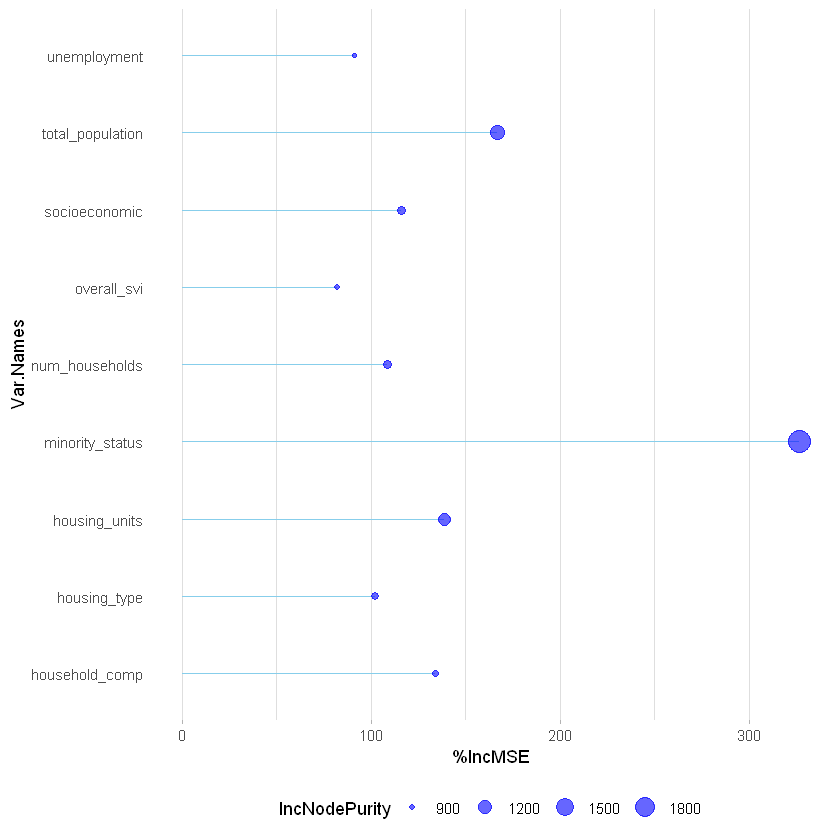

In [27]:
# Get variable importance from the model fit
ImpData <- as.data.frame(importance(rf.fit))
ImpData$Var.Names <- row.names(ImpData)

ggplot(ImpData, aes(x=Var.Names, y=`%IncMSE`)) +
  geom_segment( aes(x=Var.Names, xend=Var.Names, y=0, yend=`%IncMSE`), color="skyblue") +
  geom_point(aes(size = IncNodePurity), color="blue", alpha=0.6) +
  theme_light() +
  coord_flip() +
  theme(
    legend.position="bottom",
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.ticks.y = element_blank()
  )